In [1]:
import pandas as pd
import json
import numpy as np
from textblob import TextBlob
from wordcloud import WordCloud
import random
import re
import time
import matplotlib.pyplot as plt
import networkx as nx
import datetime

import tweepy
import jsonpickle
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
rcParams['savefig.dpi'] = 500 #图片像素
rcParams['figure.dpi'] = 500

# Data collection

In [2]:
def parse_tweets_data(data):
    
    created_at = data["created_at"]
    tweet_id = data['id']
    text = data['full_text']
    
    user_id = data['user']['id']
    user_name = data['user']['name']
    user_screen_name = data['user']['screen_name']
    user_location = data['user']['location']
    user_description = data['user']['description']
    user_friends = data['user']['friends_count']
    user_follower = data['user']['followers_count']
    
    retweet_count = data['retweet_count']
    favorite_count = data['favorite_count']
    lang = data['lang']
    
    rt_created_at = ""
    rt_tweet_id = ""
    rt_user_id = ""
    rt_user_name = ""
    rt_user_screen_name = ""
    rt_user_location = ""
    rt_user_description = ""
    rt_user_friends = ""
    rt_user_follower = ""
    
    rt_retweet_count = ""
    rt_favorite_count =""
    rt_lang =""
    is_retweet =False
    if text[:4]=='RT @':
        is_retweet = True
    
    
    ## parse retweeted_status
    try:
        if is_retweet is True:
        ##print (tweets_id)
            rt_created_at = data['retweeted_status']['created_at']
            rt_tweet_id = data['retweeted_status']['id']
            rt_user_id = data['retweeted_status']['user']['id']
            rt_user_name = data['retweeted_status']['user']['name']
            rt_user_screen_name = data['retweeted_status']['user']['screen_name']
            rt_user_location = data['retweeted_status']['user']['location']
            rt_user_description = data['retweeted_status']['user']['description']
            rt_user_friends = data['retweeted_status']['user']['friends_count']
            rt_user_follower = data['retweeted_status']['user']['followers_count']
    
            rt_retweet_count = data['retweeted_status']['retweet_count']
            rt_favorite_count = data['retweeted_status']['favorite_count']
            rt_lang = data['retweeted_status']['lang']

    except Exception as e:
        print (tweet_id," ",e)
        
    param = [created_at,tweet_id,text,user_id,user_name,user_screen_name,user_location,user_description,user_friends,user_follower,retweet_count,favorite_count,lang,is_retweet,rt_created_at,rt_tweet_id,rt_user_id,rt_user_name,rt_user_screen_name,rt_user_location,rt_user_description,rt_user_friends,rt_user_follower,rt_retweet_count,rt_favorite_count,rt_lang]

    return param

In [3]:
# Read my twitter developer keys
# config = pd.read_csv('./config.csv')

consumer_key = "yEdCvMxttz8LTusf6yldrzixI"  # config["consumer_key"][0]
# config["consumer_secret"][0]
consumer_secret = "vNNAX4QrF0VVdqhQsUsxMb9EWibKlHkpF5JeqOY3PhZkUxERIc"
# config["access_token"][0]
access_token = "965236314672164864-TKpodRBudpVhnXRvoiE0QiM3XVdfEIO"
# config["access_token_secret"][0]
access_token_secret = "EVMzWs7JGq2POpu7okReSeUIo9h35B7dT8spMe7uOORKN"

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)


api = tweepy.API(auth, proxy="127.0.0.1:10809", wait_on_rate_limit=True)

if (not api):
    print("Problem connection to API")
else:
    print("Connection is ok")


# search keywords from tweets of past 30 days
# searchQuery = "(BillieEilish OR Billiee OR @Billiee) AND Vogue"
searchQuery = "WWDC21"

maxTweets = 1500
tweetCount = 0
tweets = []

# Open a text file to save the tweets to
with open('tweets.json', 'w') as f:

    # Tell the Cursor method that we want to use the Search API (api.search)
    # Also tell Cursor our query, and the maximum number of tweets to return
    for tweet in tweepy.Cursor(api.search,q=searchQuery, tweet_mode="extended").items(maxTweets) :         
        #Write the JSON format to the text file, and add one to the number of tweets we've collected
        data = parse_tweets_data(tweet._json)
        tweets.append(data)
        f.write(jsonpickle.encode(tweet._json, unpicklable=False) + '\n')
        tweetCount += 1
        print(tweetCount)
    # Display how many tweets we have collected
    print("Downloaded {0} tweets".format(tweetCount))


Connection is ok


TweepError: Failed to send request: HTTPSConnectionPool(host='api.twitter.com', port=443): Max retries exceeded with url: /1.1/search/tweets.json?q=WWDC21&tweet_mode=extended (Caused by ProxyError('Cannot connect to proxy.', NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7fa0f852d0d0>: Failed to establish a new connection: [Errno 61] Connection refused')))

In [5]:
columns = "created_at,tweet_id,text,user_id,user_name,user_screen_name,user_location,user_description,user_friends,user_follower,retweet_count,favorite_count,lang,is_retweet,rt_created_at,rt_tweet_id,rt_user_id,rt_user_name,rt_user_screen_name,rt_user_location,rt_user_description,rt_user_friends,rt_user_follower,rt_retweet_count,rt_favorite_count,rt_lang".split(
    ',')
df = pd.DataFrame(data=tweets, columns=columns)
df.head(5)

,created_at,tweet_id,text,user_id,user_name,user_screen_name,user_location,user_description,user_friends,user_follower,...,rt_user_id,rt_user_name,rt_user_screen_name,rt_user_location,rt_user_description,rt_user_friends,rt_user_follower,rt_retweet_count,rt_favorite_count,rt_lang


In [6]:
import pymongo

myclient = pymongo.MongoClient("mongodb://localhost:27017/")
DBName = "twitter_content"
ColName = "WWDC21"

mydb = myclient[DBName]
mycol = mydb[ColName]
#判断DB是否存在
dblist = myclient.list_database_names()
# dblist = myclient.database_names() 
if DBName in dblist:
    print("数据库已存在！")
    
else:
    print("新建数据库twitter_content")

    
# 判断集合是否存在    
collist = mydb.list_collection_names()
if ColName in collist:   
  print("集合已存在！")



docs = mycol.find()
tweet_ids = []
for doc in docs:
    tweet_ids.append(doc['tweet_id'])
print('all len is ', len(tweet_ids))
print('unique len is ', len(set(tweet_ids)))

data = df.to_dict('records')
arr = []
for line in data:
    if line['tweet_id'] in tweet_ids:
        continue
    tweet_ids.append(line['tweet_id'])
    one = pymongo.UpdateOne(line, {'$setOnInsert': line}, upsert=True)
    arr.append(one)
    if len(arr) == 10000:
        mycol.bulk_write(arr)
        arr = []
        print("writen ", 10000, ' line.')
if len(arr) != 0:
    mycol.bulk_write(arr)
    print("writen ", len(arr), ' line.')


数据库已存在！
集合已存在！
all len is  3000
unique len is  3000


# Compute Popularity
## PageRank popularity

In [7]:
myclient = pymongo.MongoClient("mongodb://localhost:27017/")
DBName = "twitter_content"
ColName = "WWDC21"

mydb = myclient[DBName]
mycol = mydb[ColName]
#判断DB是否存在
dblist = myclient.list_database_names()
# dblist = myclient.database_names() 
if DBName in dblist:
    print("数据库已存在！")
    
else:
    print("新建数据库twitter_content")

    
# 判断集合是否存在    
collist = mydb.list_collection_names()
if ColName in collist:
    print("集合已存在！")

docs = mycol.find()
edges = []
for doc in docs:
    if doc['is_retweet']:
        edges.append([doc['rt_tweet_id'], doc['tweet_id']])

# 读入有向图，存储边
# f = open('input.txt', 'r')
# edges = [line.strip('\n').split(' ') for line in f]
# print(edges)

# 根据边获取节点的集合
nodes = []
for edge in edges:
    if edge[0] not in nodes:
        nodes.append(edge[0])
    if edge[1] not in nodes:
        nodes.append(edge[1])
# print('nodes :', nodes)

N = len(nodes)

# 将节点符号（字母），映射成阿拉伯数字，便于后面生成A矩阵/S矩阵
i = 0
node_to_num = {}
for node in nodes:
    node_to_num[node] = i
    i += 1
for edge in edges:
    edge[0] = node_to_num[edge[0]]
    edge[1] = node_to_num[edge[1]]
# print('edges :', edges)

# 生成初步的S矩阵
S = np.zeros([N, N])
for edge in edges:
    S[edge[1], edge[0]] = 1
# print('S - before :', S)

# 计算比例：即一个网页对其他网页的PageRank值的贡献，即进行列的归一化处理
for j in range(N):
    sum_of_col = S[:,j].sum()
    if sum_of_col != 0:
        for i in range(N):
            S[i, j] /= sum_of_col
# print('S - after :',S)

# 计算矩阵A
alpha = 0.85
A = alpha*S + (1-alpha) / N * np.ones([N, N])
# print('A :', A)

# 生成初始的PageRank值，记录在P_n中，P_n和P_n1均用于迭代
P_n = np.ones(N) / N
# P_n1 = np.zeros(N)


e = 100000  # 误差初始化
k = 0   # 记录迭代次数
print('loop...')

while e > 0.00000001:   # 开始迭代
    P_n = P_n1 if k != 0 else P_n
    P_n1 = np.dot(A, P_n)   # 迭代公式
    sum_of_P = P_n1.sum()
    P_n1 = P_n1/sum_of_P
#     P_n = P_n1
    k += 1
    e = P_n1-P_n
    e = max(map(abs, e))    # 计算误差
#     print('e :', e)
#     print('iteration %s:'%str(k), P_n1)

print('final result:', P_n)

数据库已存在！
集合已存在！
loop...
final result: [0.0001754  0.00025138 0.0001754  ... 0.00044134 0.00044134 0.00030837]


In [8]:
PR = dict(zip(nodes, P_n))

In [67]:
pd.DataFrame.from_dict({k : v for k, v in sorted(PR.items(), key=lambda item: item[1], reverse=True) }, orient='index', columns=['PR'])

,PR
1401993791989506000,0.000707
1401994330785554400,0.000707
1401994321784545300,0.000707
1401994298703454200,0.000707
1401993922361151500,0.000707
...,...
1401992908077551600,0.000175
1401969465420615700,0.000175
1401949518283804700,0.000175
1401962379907305500,0.000175


## hashtag part

In [14]:
df = pd.DataFrame(list(mycol.find()))

In [15]:
df.iloc[0]

_id                                             60be75d1974be68646bf2778
created_at                                Mon Jun 07 19:32:26 +0000 2021
favorite_count                                                         0
hashtags                                                              []
is_retweet                                                          True
lang                                                                  th
retweet_count                                                        390
rt_created_at                             Mon Jun 07 18:25:29 +0000 2021
rt_favorite_count                                                     54
rt_lang                                                               th
rt_retweet_count                                                     390
rt_tweet_id                                          1401968570901229600
rt_user_description    แฟนพันธุ์แท้สตีฟจ็อบส์ , Founder of MacThai / ...
rt_user_follower                                   

In [11]:
punctuation = '!,;:?"\'、，；'
def removePunctuation(text):
    text = re.sub(r'[{}]+'.format(punctuation),' ',text)
    return text.strip()

In [16]:
tweets_with_hashtag = df[df['text'].str.contains("#")].copy()
tweets_with_hashtag['hashtags'] = tweets_with_hashtag['text'].apply(lambda x:\
                                                                         list(filter(lambda y:\
                                                                                      '#' in y,\
                                                                                      x.split()))\
                                                                         )
tweets_with_hashtag['hashtags'] = tweets_with_hashtag['hashtags'].apply(lambda x :\
                                                                        [removePunctuation(tmp[tmp.index('#'):]) for tmp in x])
# tweets_with_hashtag['hashtag_num'] = tweets_with_hashtag['hashtags'].apply(lambda x: len(x))
tweets_with_hashtag.head(1)

,_id,created_at,favorite_count,hashtags,is_retweet,lang,retweet_count,rt_created_at,rt_favorite_count,rt_lang,...,user_description,user_follower,user_friends,user_id,user_location,user_mentions,user_name,user_screen_name,popularity_state,popularity_mobile
1,60be75d1974be68646bf2779,Mon Jun 07 19:32:26 +0000 2021,0,[#للمصمم…],True,ar,4,Mon Jun 07 18:29:24 +0000 2021,5,ar,...,سبحان الله وبحمده سبحان الله العظيم ♡,3664,2403,704817138524094500,المملكة العربية السعودية,[1220474752340500500],فيصل مفرح رشيد العنزي♿️🇸🇦,MfoFaisal,566.070727,566.070727


In [27]:
hashtags = {}
min_created_time = time.strftime('%a %b %d %H:%M:%S %z %Y', time.localtime()) 
min_created_time = datetime.datetime.strptime(min_created_time, '%a %b %d %H:%M:%S %z %Y')
for index, row in tweets_with_hashtag.iterrows():
#     print(row)
    time_stamp = datetime.datetime.strptime(row['created_at'], '%a %b %d %H:%M:%S %z %Y')
    if time_stamp < min_created_time:
        min_created_time = time_stamp
    row_hashtags = row['hashtags']
    tmp_info = {'tweet_id': row['tweet_id'], 
                'rt_tweet_id': row['rt_tweet_id'],
                'created_at': time_stamp,
                'popularity' : row['popularity_state'],
                'hashtag_num': len(row_hashtags)} # TODO: more cols
    for i_ht in row_hashtags:
        if i_ht not in hashtags:
            hashtags[i_ht] = [tmp_info]
        else:
            hashtags[i_ht].append(tmp_info)
hashtags.keys()

dict_keys(['#للمصمم…', '#W…', '#WWDC21', '#M1X', '#MacBookPro', '#AppleEvent', '#iosdev', '#SwiftUI', '#swift', '#Apple', '#iOS', '#SwiftLang', '#iOSDev', '#swiftlang', '#io…', '#Xcode13', '#WWD…', '#ios', '#macOS', '#iOS15.', '#100DaysOfSwiftUI', '#LangsungTwitterXavierNaxa', '#RealityKit2', '#Swift', '#Actors', '#wwdc21', '#iOS15', '#watchos', '#مؤتمر_آبل', '#…', '#Butter2ndNo1OnHot100', '#MondayMotivation', '#mondaythoughts', '#iPadOS15', '#m1', '#ipadpro', '#GoogleIO2021', '#مؤتمر_ابل', '#macOSMonterey', '#architecturerender', '#landscapearchitect', '#IMissTheEraOf', '#3dinteriordesign', '#3dhousedesign', '#exteriorrendering', '#WWDC…', '#Tecnología', '#7Jun', '#sketchnote', '#sketchnoting', '#sus', '#wylsacom', '#apple', '#macOS12', '#iRobinPro', '#مؤتمر_أبل', '#TaylorsVersion)”', '#WWDC21…', '#dubdub', '#DSGVO', '#twlz', '#BolsonaroReeleito', '#LoveHYUNJIN', '#design', '#Safari', '#TopBrasilSpotify', '#LoveHyunjin', '#bbtvi', '#followtrick', '#موتمرApple', '#MacOS12', '#macos', '

In [32]:
hashtags['#COVIDEmergency2021'][0]['created_at'] - min_created_time

datetime.timedelta(seconds=69)

In [36]:
hashtag_popularity = {}
hashtag_pop_changes = {}
hashtag_connections = [[0] * len(hashtags)] * len(hashtags)
for i_ht in hashtags:
    sum_pop = 0
    hashtag_pop_changes[i_ht] = {min_created_time : 0}
    for i_tw in hashtags[i_ht]:
        if i_tw['created_at'] in hashtag_pop_changes[i_ht]:
            hashtag_pop_changes[i_ht][i_tw['created_at']] += i_tw['popularity']
        else:
            hashtag_pop_changes[i_ht][i_tw['created_at']] = i_tw['popularity']
        sum_pop += i_tw['popularity'] / i_tw['hashtag_num']
    hashtag_popularity[i_ht] = sum_pop

In [45]:
# hashtag_pop_changes['#COVIDEmergency2021']
L = {k : v for k, v in sorted(hashtag_pop_changes.items(), key=lambda item: len(item), reverse=True)[:20] }

In [55]:
L['#iOS'].keys()

dict_keys([datetime.datetime(2021, 6, 7, 19, 27, 6, tzinfo=datetime.timezone.utc), datetime.datetime(2021, 6, 7, 19, 32, 24, tzinfo=datetime.timezone.utc), datetime.datetime(2021, 6, 7, 19, 29, 35, tzinfo=datetime.timezone.utc), datetime.datetime(2021, 6, 7, 19, 29, 19, tzinfo=datetime.timezone.utc), datetime.datetime(2021, 6, 7, 19, 29, 17, tzinfo=datetime.timezone.utc), datetime.datetime(2021, 6, 7, 19, 27, 46, tzinfo=datetime.timezone.utc), datetime.datetime(2021, 6, 7, 20, 10, 2, tzinfo=datetime.timezone.utc), datetime.datetime(2021, 6, 7, 20, 9, 21, tzinfo=datetime.timezone.utc), datetime.datetime(2021, 6, 7, 20, 5, 51, tzinfo=datetime.timezone.utc), datetime.datetime(2021, 6, 7, 20, 3, 52, tzinfo=datetime.timezone.utc)])

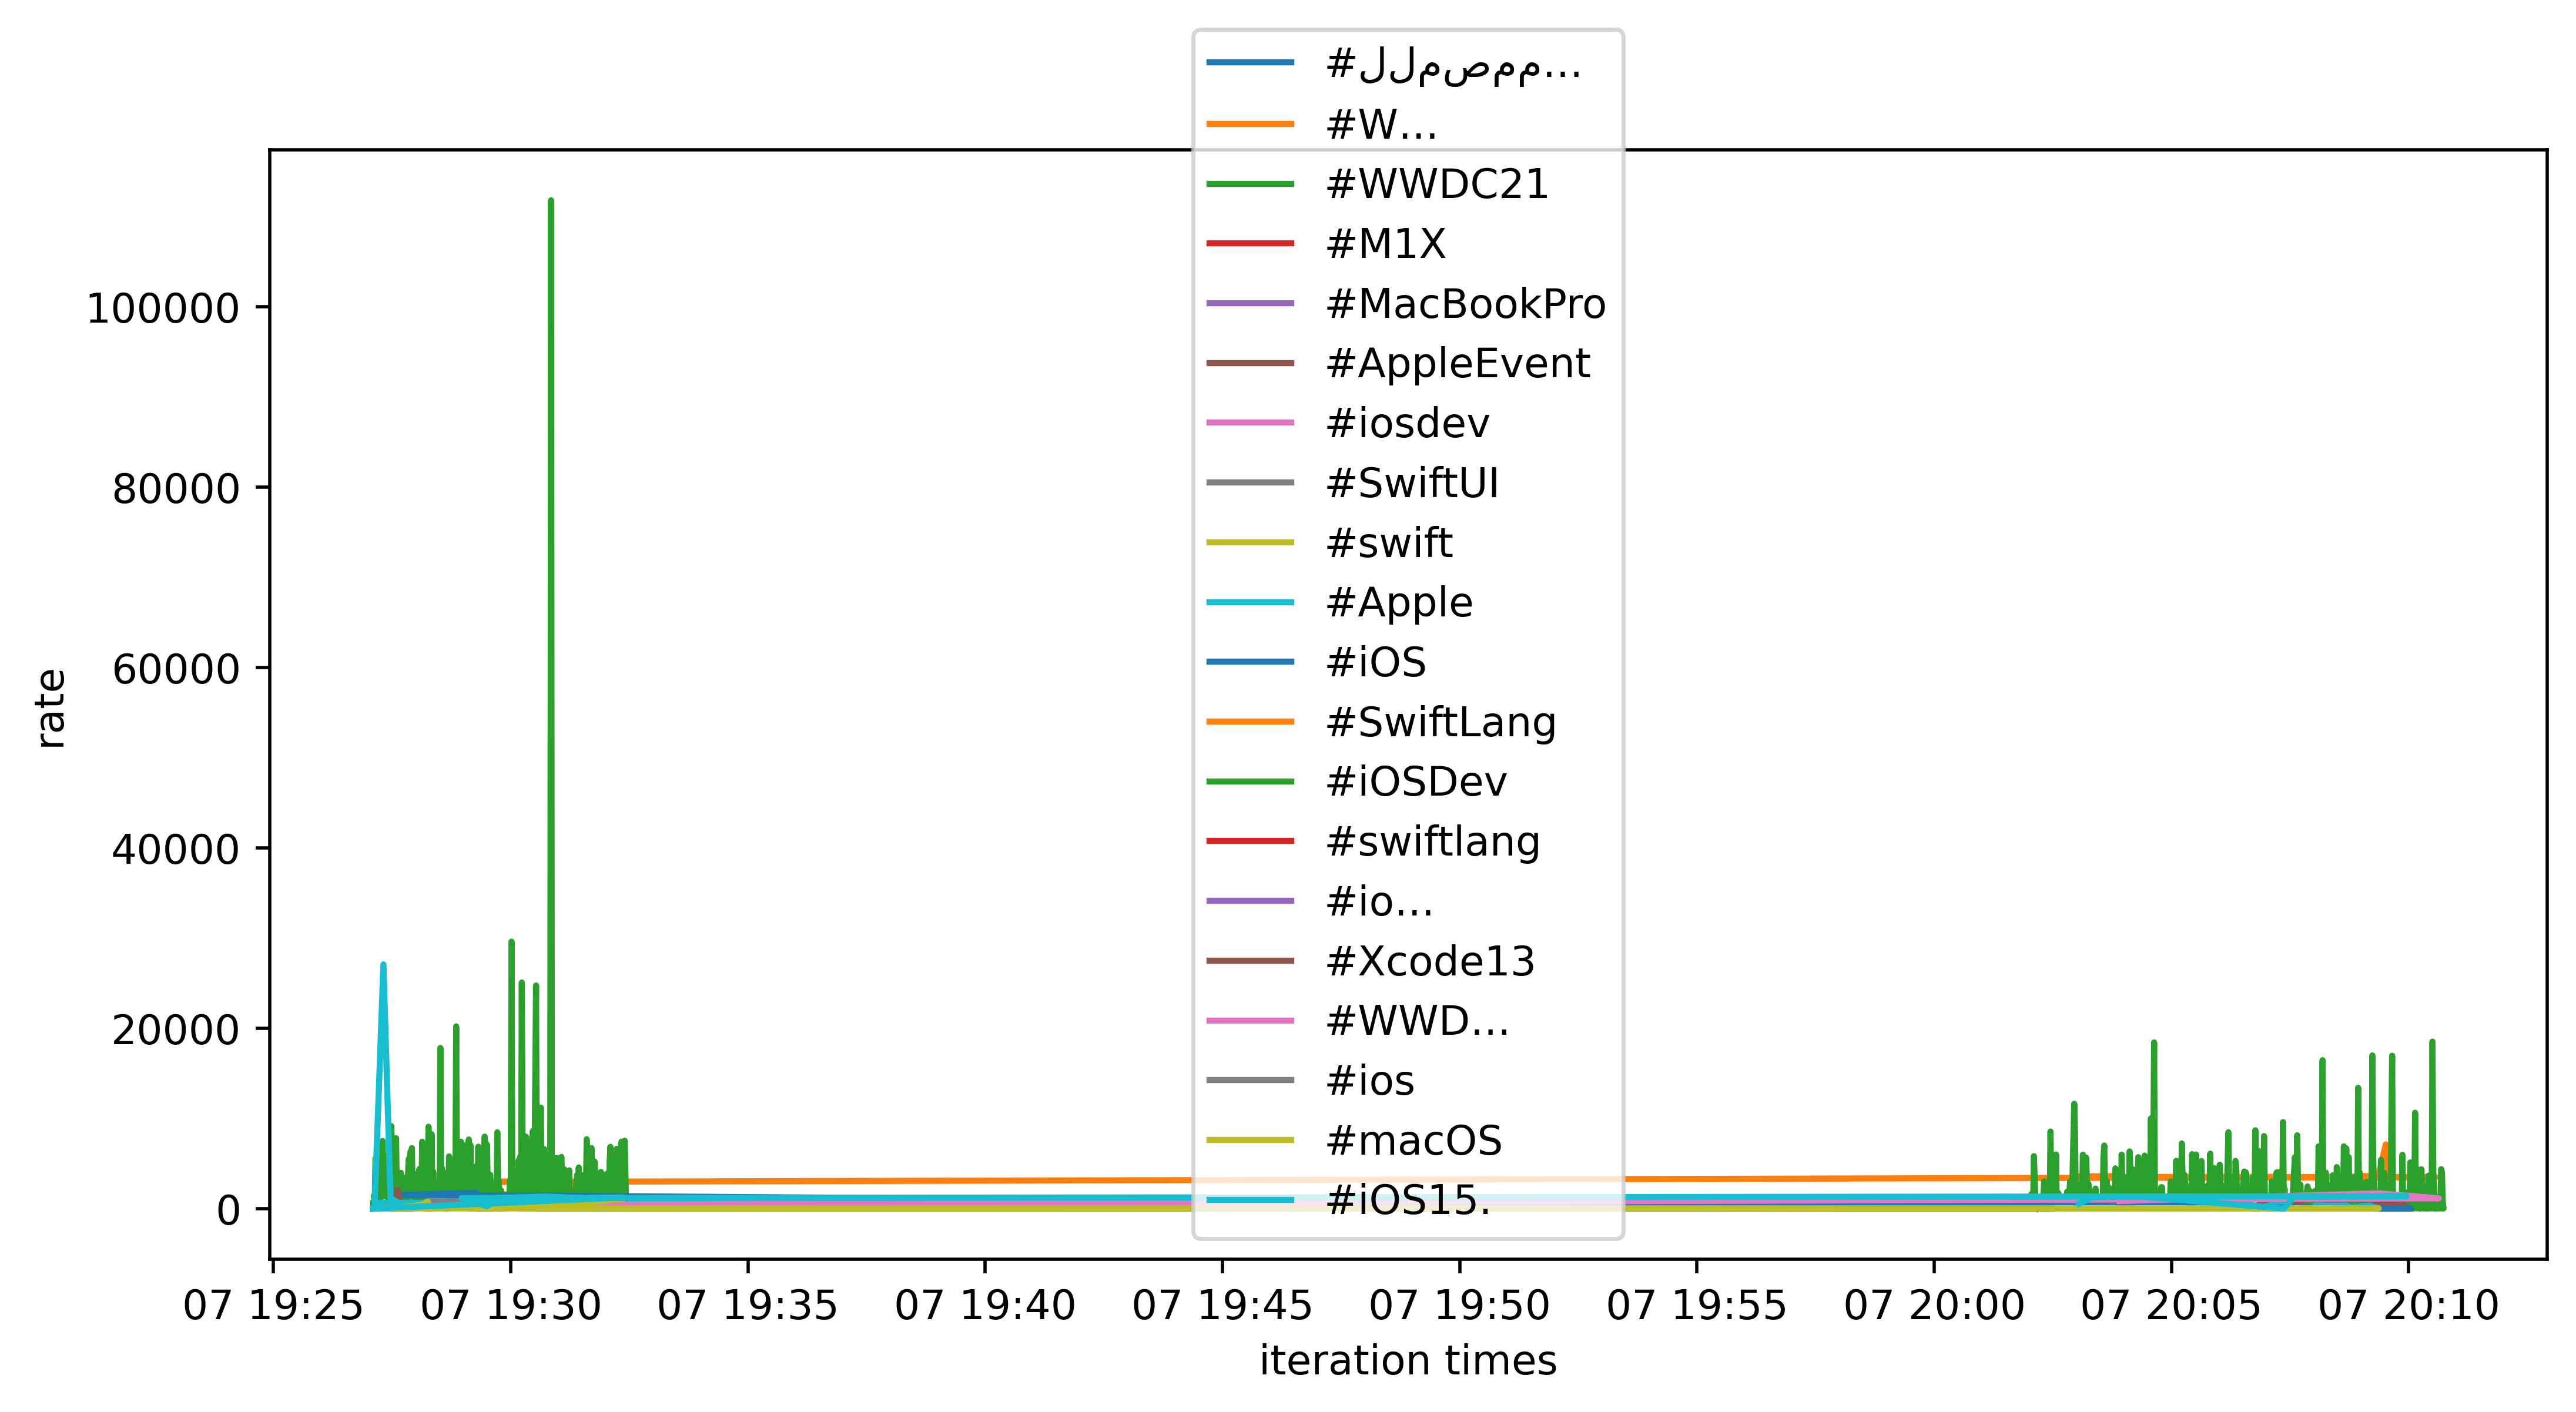

In [57]:
for k in L:
    plt.plot(list(L[k].keys()), list(L[k].values()), label=k)
plt.legend() # 显示图例

plt.xlabel('iteration times')
plt.ylabel('rate')
plt.show()

{'#apple': 2305.502606445993, '#iPadOS15': 2426.287338771839, '#wwdc…': 3157.123347006617, '#WWDC': 4101.666803997059, '#WWD…': 4112.176534159, '#Butter2ndNo1OnHot100': 4137.174601426777, '#macos': 7038.74314589351, '#エンガジェット': 7899.62363063747, '#WWDC…': 8952.423228172232, '#7Jun': 9623.70193568102, '#Tecnología': 9623.70193568102, '#iOS15.': 12002.921847030828, '#Apple': 19171.77944034553, '#AppleEvent': 20423.638909258683, '#WWDC21…': 38999.45635072616, '#LangsungTwitterXavierNaxa': 76239.97942422549, '#iOS15': 98495.67515934845, '#W…': 146115.82494554896, '#wwdc21': 545560.4515467909, '#WWDC21': 1560038.8175753895}


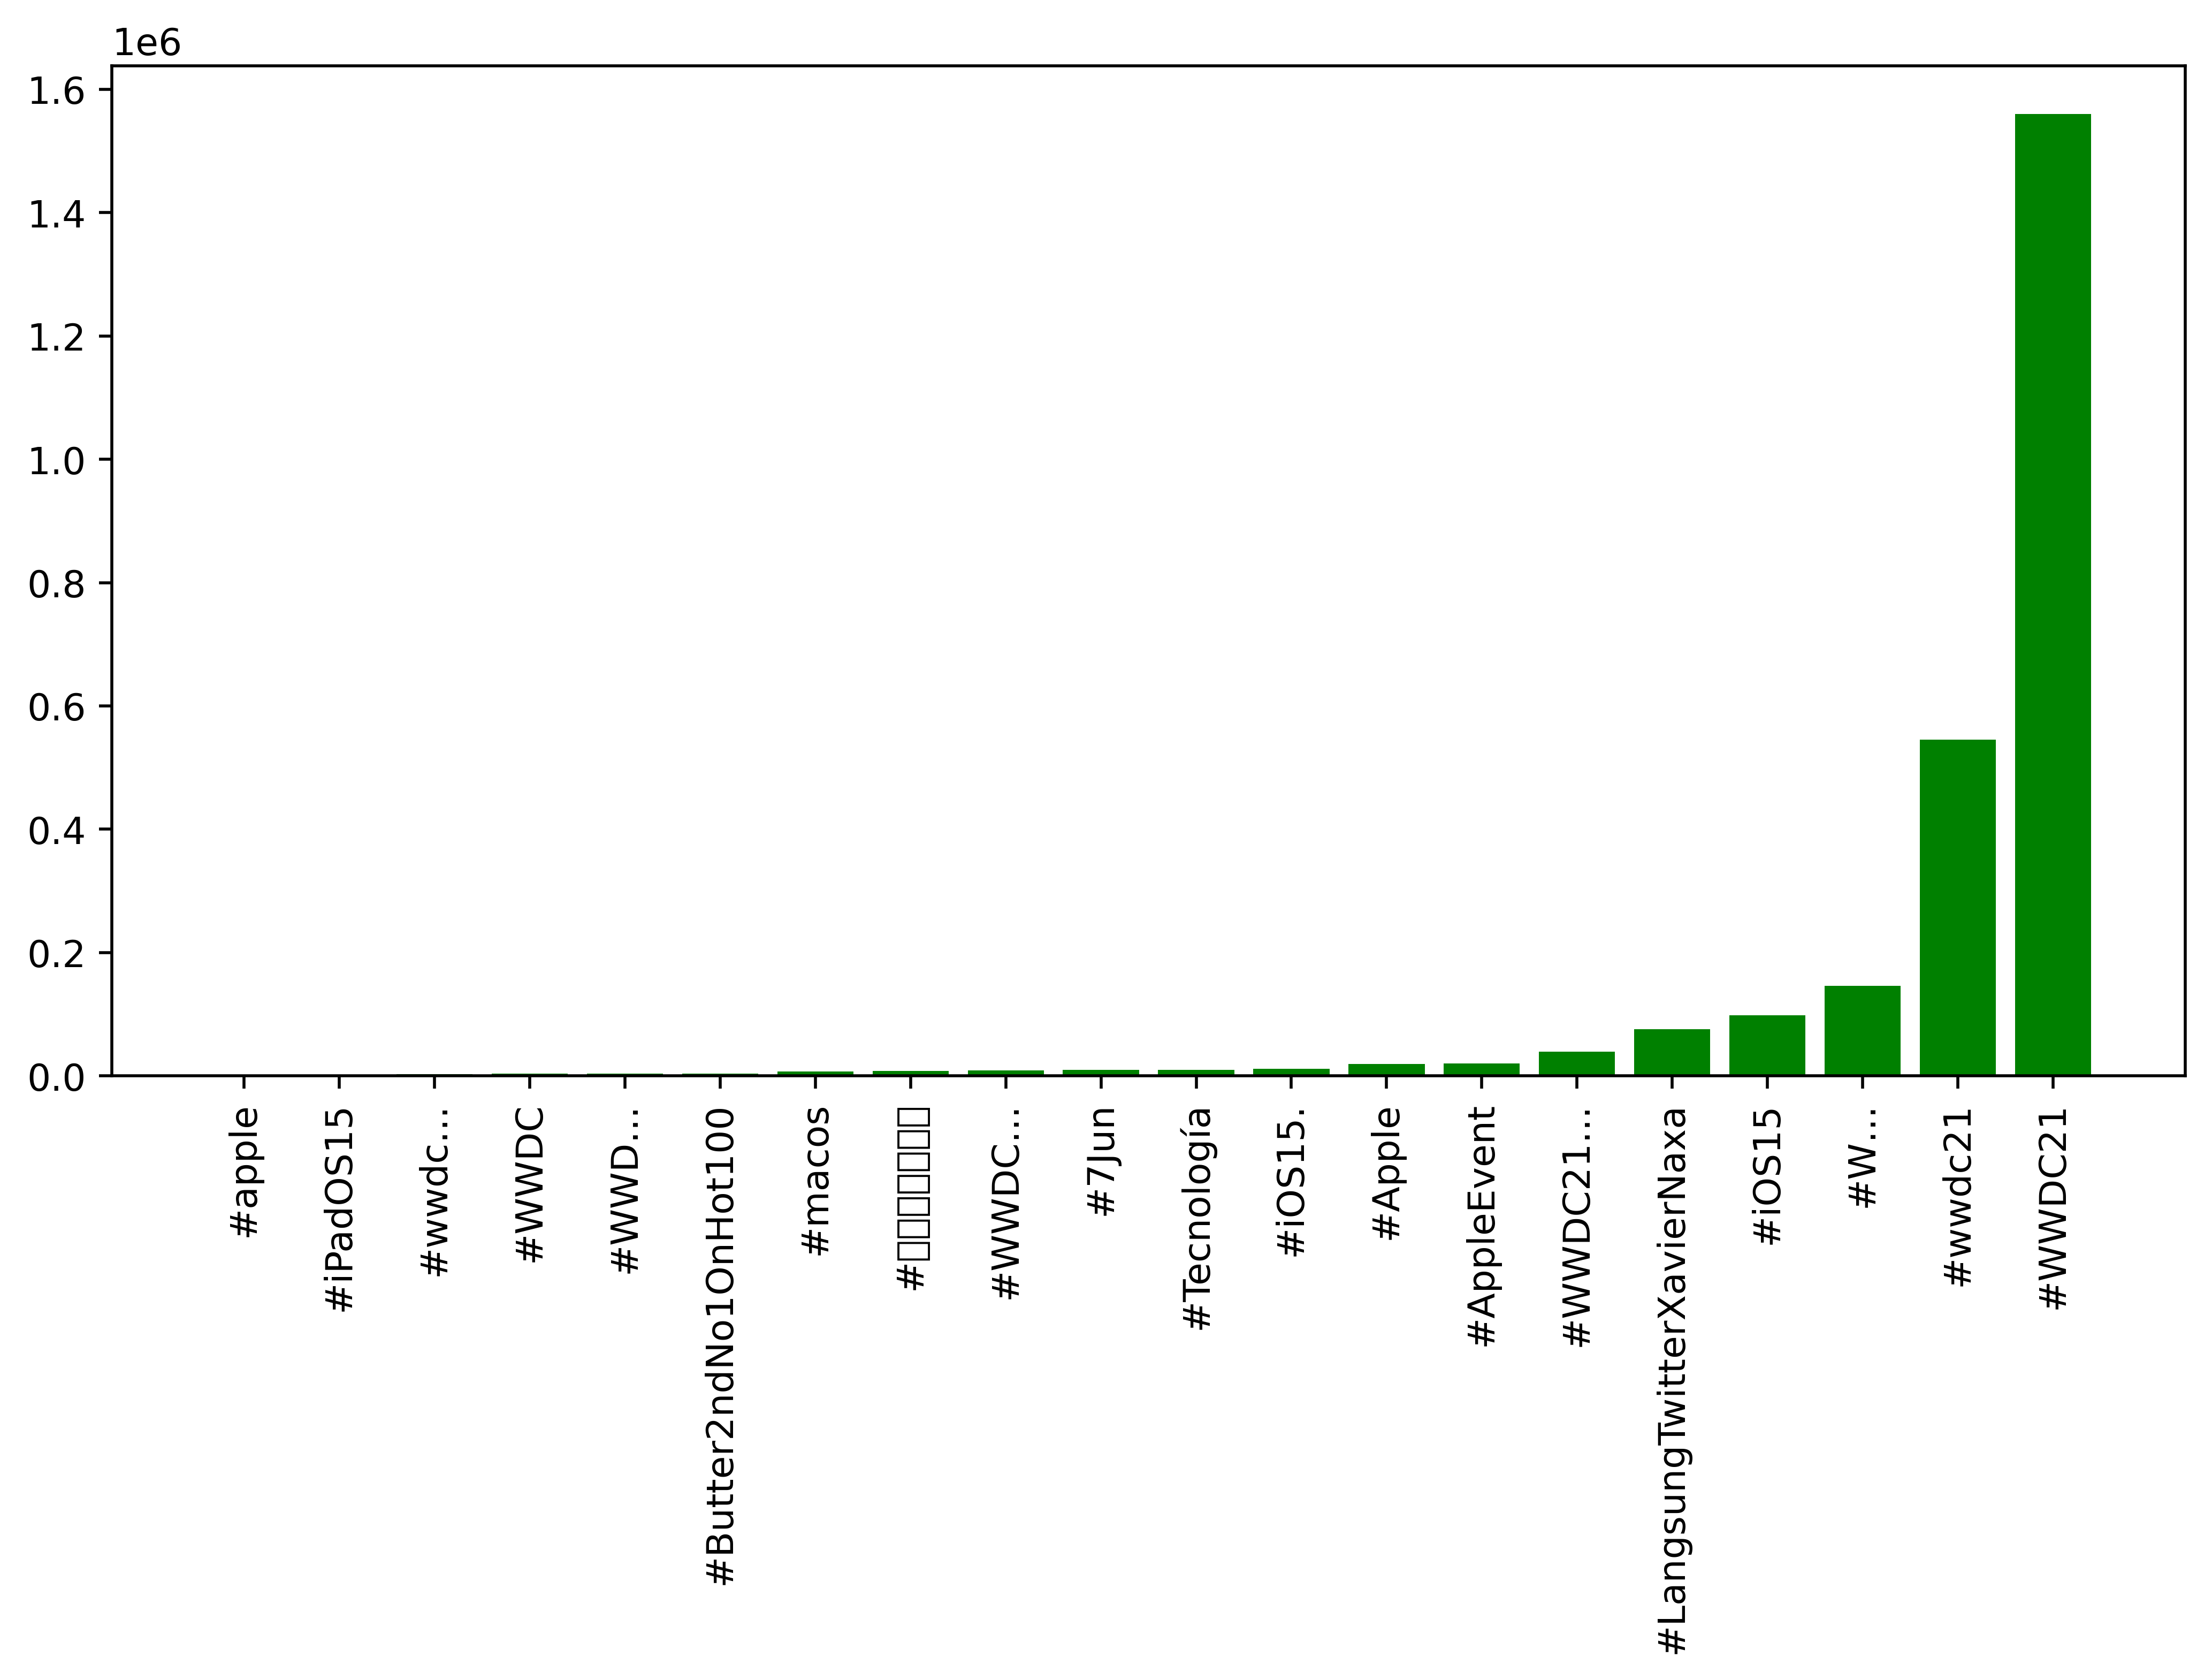

In [26]:
kv = {k : v for k, v in sorted(hashtag_popularity.items(), key = lambda kv:(kv[1], kv[0]))[-20:]}
print(kv)
plt.bar(list(kv.keys()), kv.values(), color='g')
plt.xticks(list(kv.keys()), list(kv.keys()), rotation=90)
plt.show()

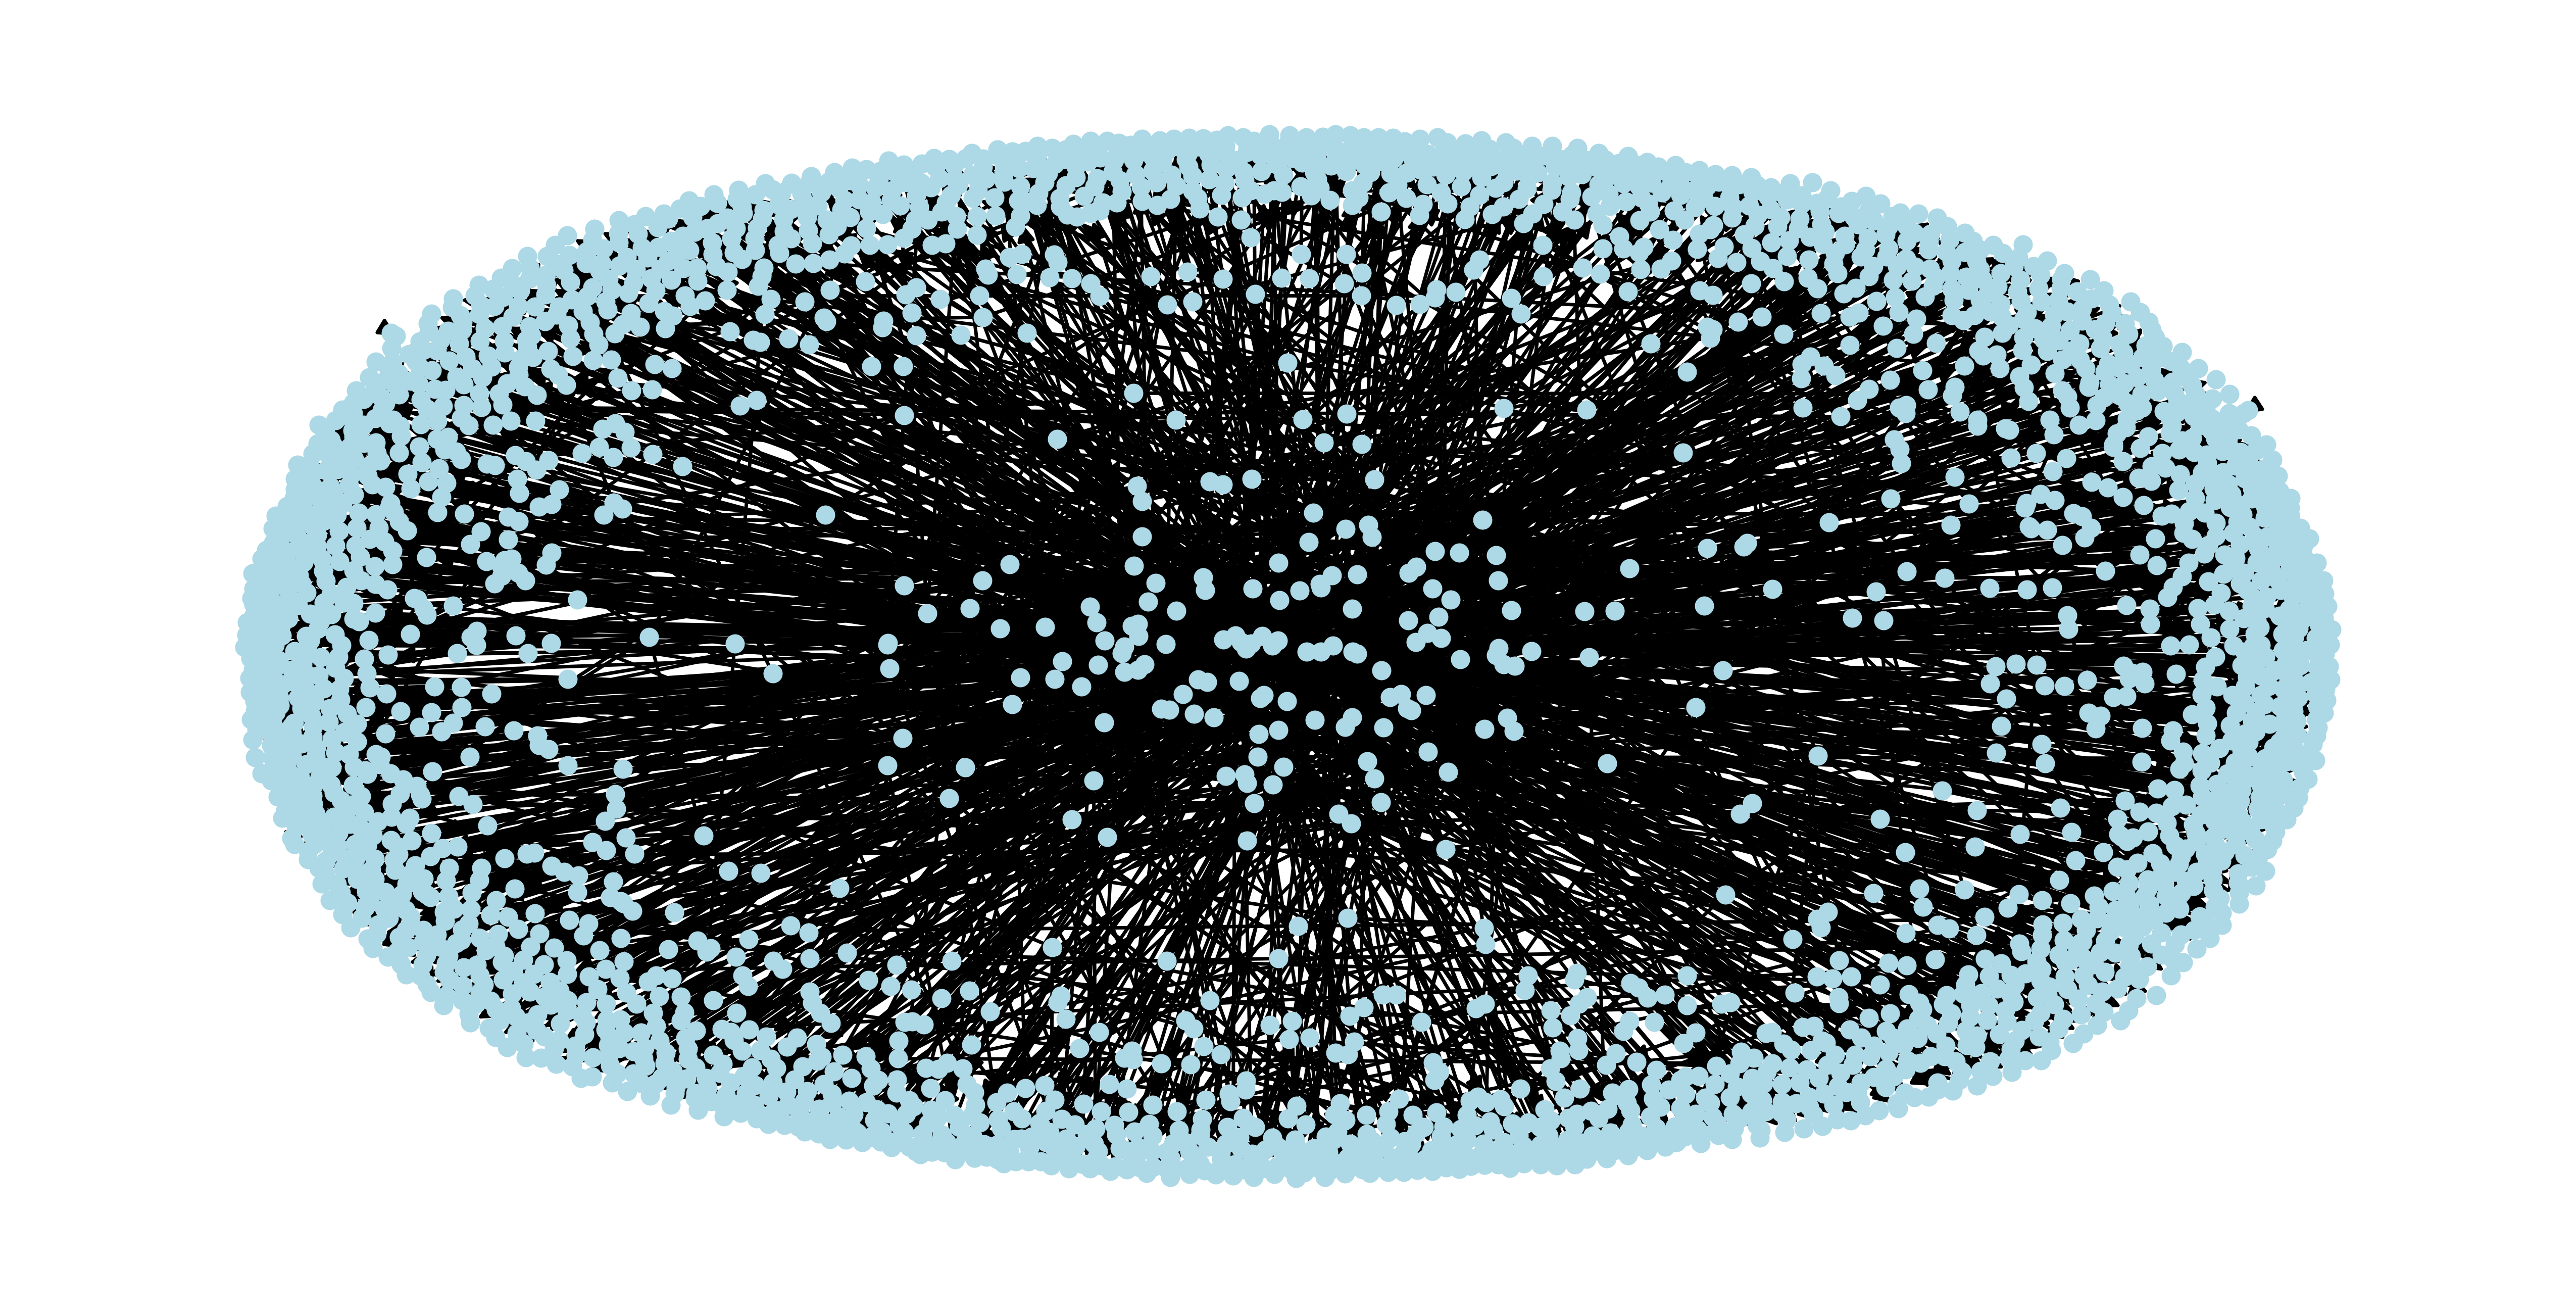

In [46]:
import networkx as nx
import matplotlib.pyplot as plt

options = {
    'node_color': 'lightblue',
    'node_size': 20,
}
G = nx.DiGraph()
for edge in edges:
    G.add_edge(edge[0], edge[1])
nx.draw(G, with_labels=False, **options)
plt.show()